# Walkthrough - Enhancing SAMap analysis with `comandos`

In this notebook I will try to go through a normal SAMap analysis workflow and show how `comandos`
visualizations can be used to guide the analysis.

In [1]:
from datetime import date
import pickle
import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import scanpy as sc

from samap import SAMAP
from samap import *
from samalg import SAM

from comandos import plot as cmd

/opt/homebrew/Caskroom/miniforge/base/envs/comandos_dev/lib/python3.14/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
print(date.today())

2026-02-23


In [3]:
os.environ["EXAMPLE_DATA_PATH"] = "../example_data/"

In [4]:
file = open(os.environ["EXAMPLE_DATA_PATH"] + "hypl.pkl", "rb")
hypl = pickle.load(file)

file = open(os.environ["EXAMPLE_DATA_PATH"] + "hysc.pkl", "rb")
hysc = pickle.load(file)

Go on with mapping clusters between species.

In [5]:
keys = {"hy": "Cluster", "pl": "cluster"}
D, MappingTable = get_mapping_scores(hypl, keys)

query_clusters = MappingTable.index[MappingTable.index.str.startswith("hy")]
target_clusters = MappingTable.index[MappingTable.index.str.startswith("pl")]

hypl_toplot = MappingTable.loc[target_clusters][query_clusters]

In [6]:
keys = {"hy": "Cluster", "sc": "cluster_t"}
D, MappingTable = get_mapping_scores(hysc, keys)

query_clusters = MappingTable.index[MappingTable.index.str.startswith("hy")]
target_clusters = MappingTable.index[MappingTable.index.str.startswith("sc")]

hysc_toplot = MappingTable.loc[target_clusters][query_clusters]

In [7]:
hypl.sams["hy"].adata.obs["coarse"] = (
    hypl.sams["hy"].adata.obs["Cluster"].str.split("_").str[0]
)
hypl.sams["pl"].adata.obs["coarse"] = (
    hypl.sams["pl"].adata.obs["tissue_smedwi"].str.split("_").str[0]
)

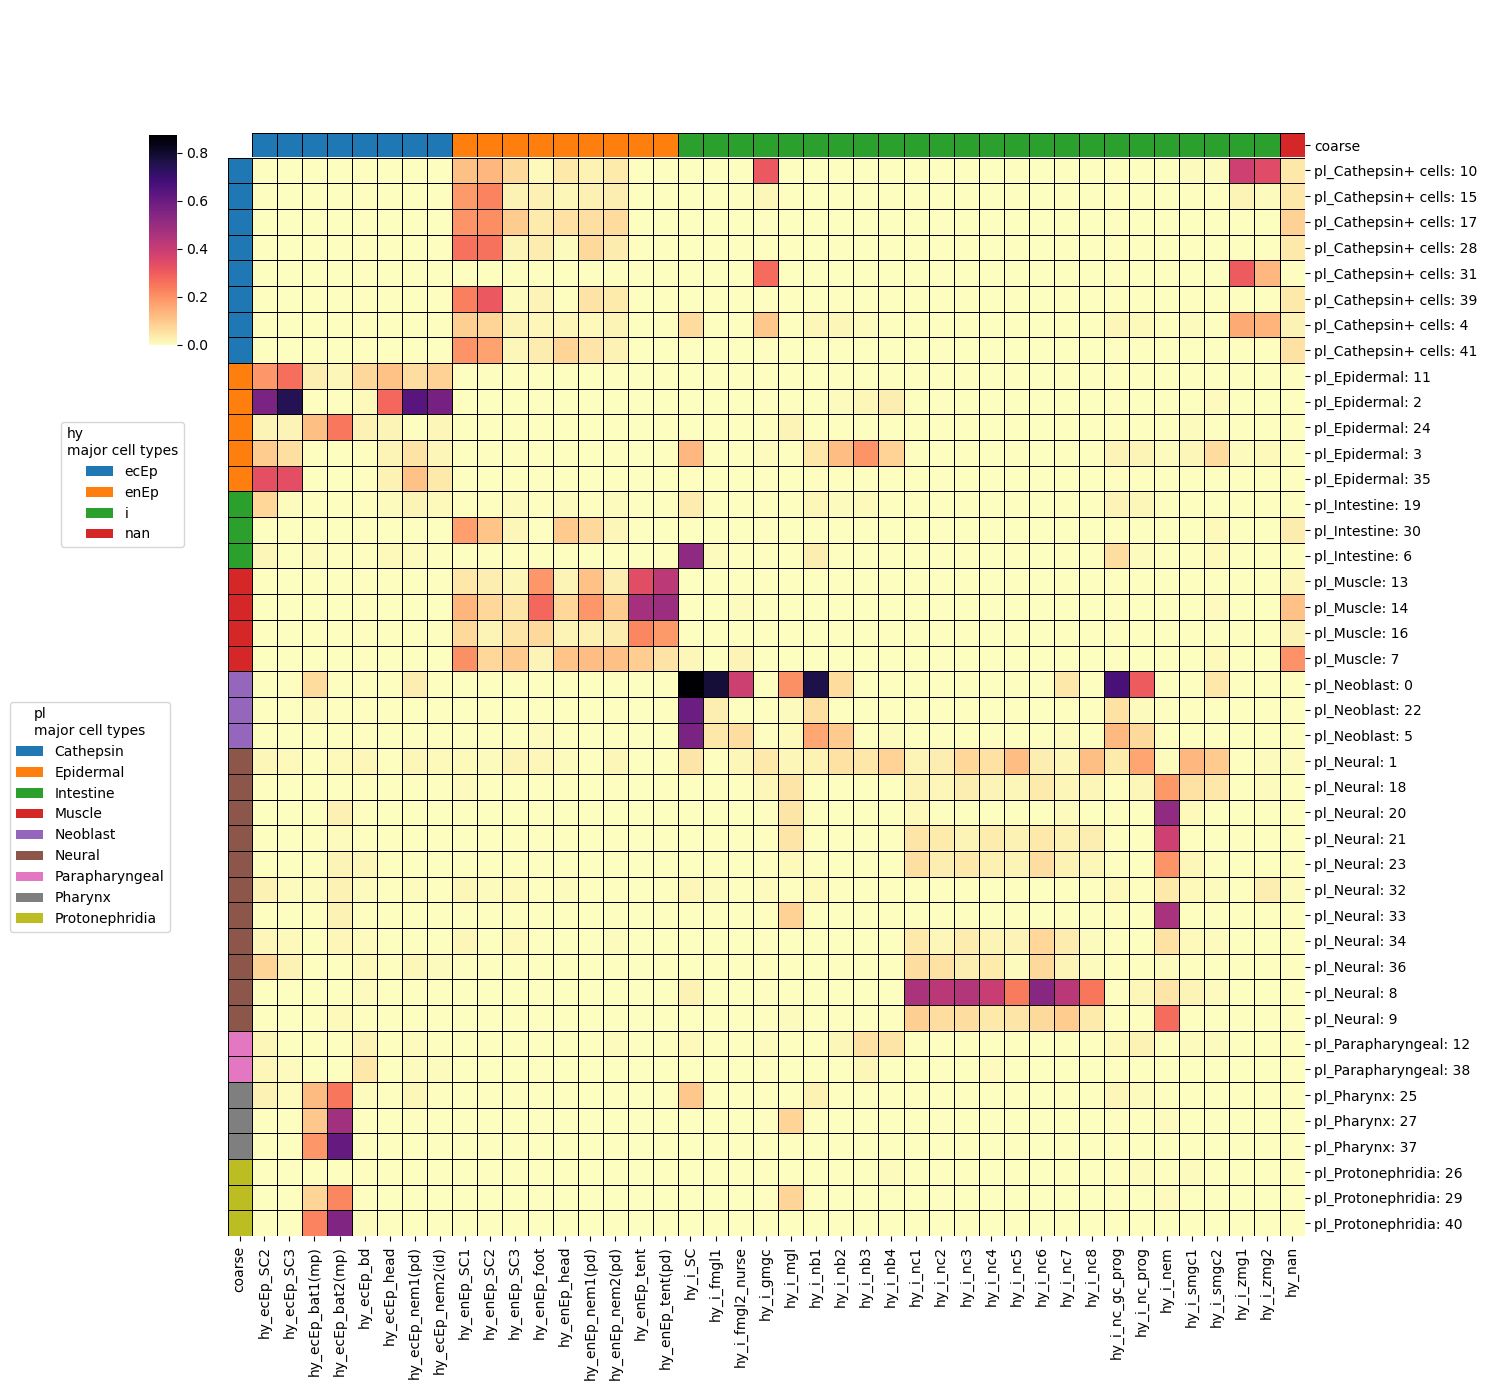

In [8]:
cmd.annotated_heatmap(
    hypl,
    hypl_toplot,
    "hy",
    "pl",
    query_clustering="Cluster",
    target_clustering="cluster",
    query_coarse="coarse",
    target_coarse="coarse",
    interactive=False
)

In [9]:
hysc.sams["hy"].adata.obs["coarse"] = (
    hysc.sams["hy"].adata.obs["Cluster"].str.split("_").str[0]
)
hysc.sams["sc"].adata.obs["coarse"] = (
    hysc.sams["sc"].adata.obs["cluster_t"].str.split(":").str[0]
)

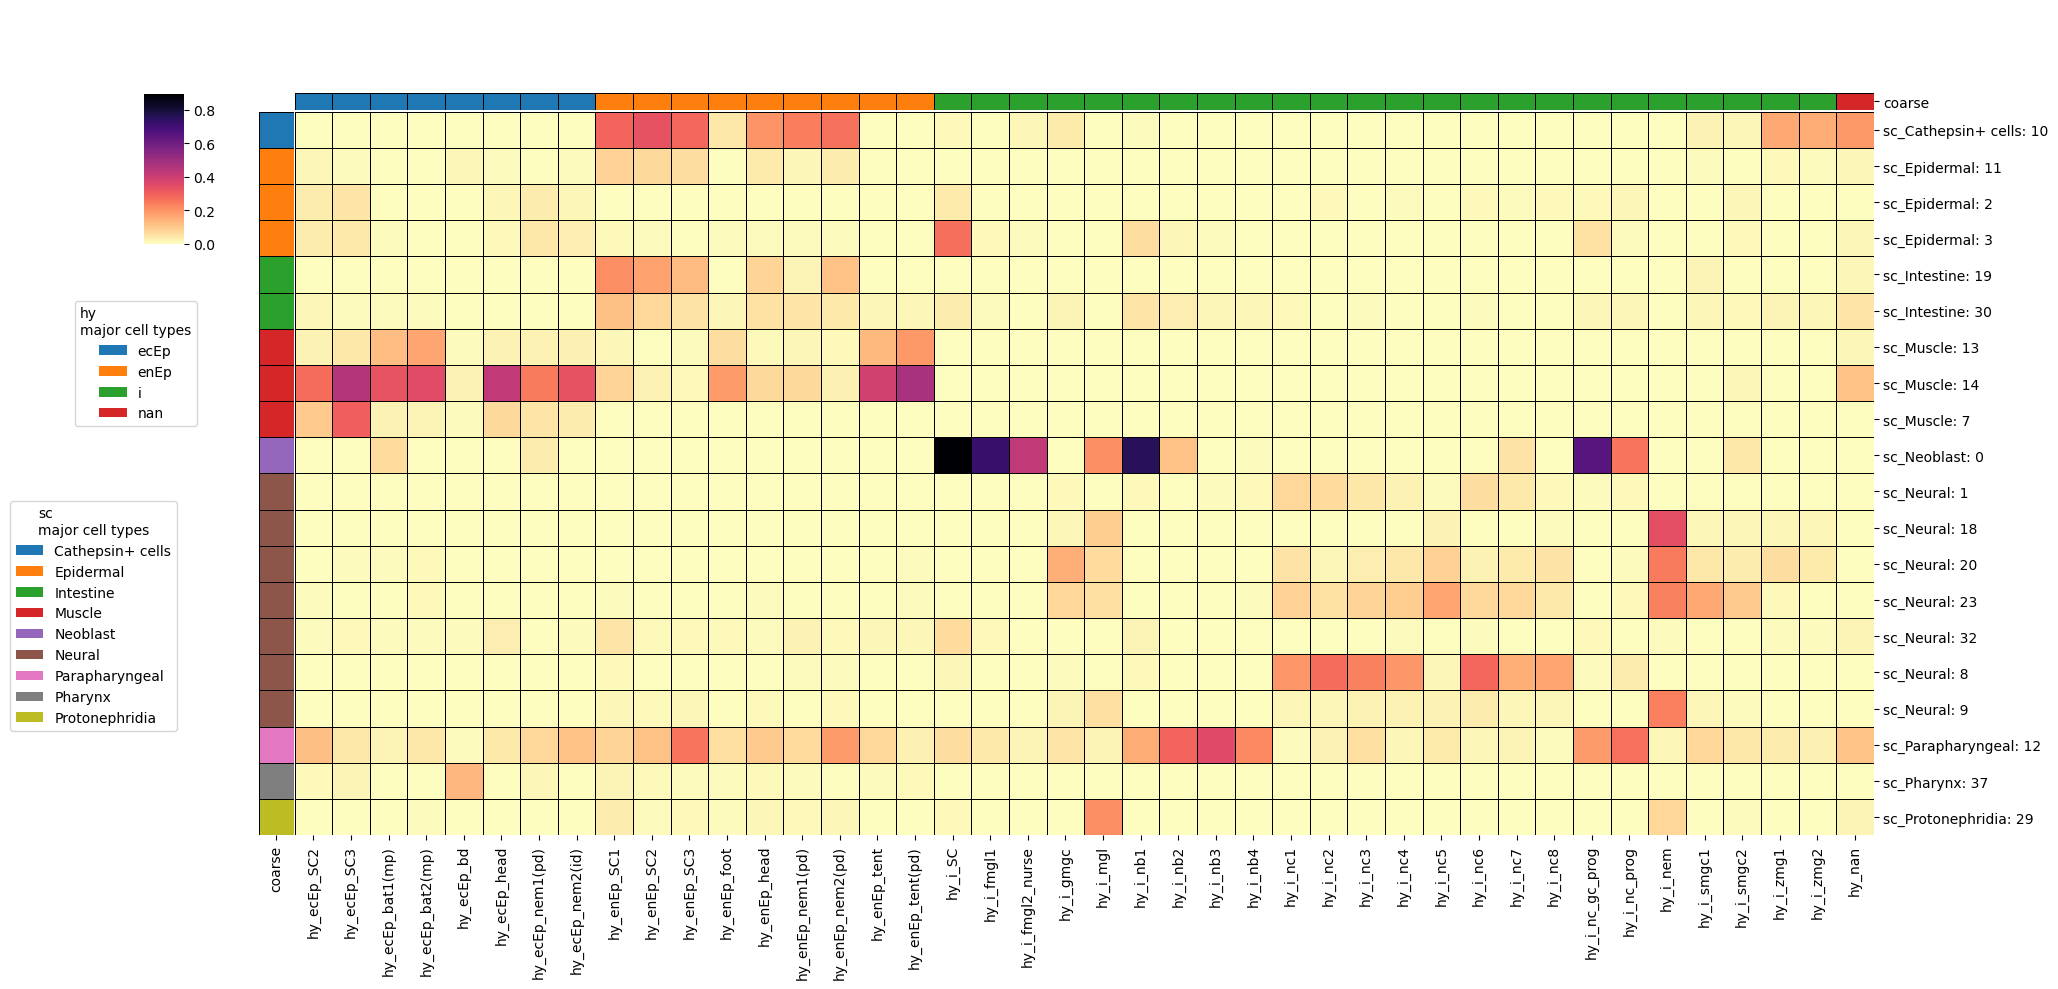

In [10]:
cmd.annotated_heatmap(
    hysc,
    hysc_toplot,
    "hy",
    "sc",
    query_clustering="Cluster",
    target_clustering="cluster_t",
    query_coarse="coarse",
    target_coarse="coarse",
    interactive=False,
    figsize=(20, 10)
)

The lived experience of evolutionary research is that one-to-one comparisons rarely show us the
entire truth. Rather, we should try to look at as many data points at once as possible, and see the
bigger patterns. While the hydra-to-planarian or the hydra-to-schistostome comparison may not, on
their own, strongly identify clusters, they may offer accumulated weak evidence for cell type
similarity, that on aggregate cannot be ignored.

Happily, SAMap similarity scores exist in the the same space (0-1), which means we can simply
concatenate the pairwise similarity matrices and so see what all flatworms think about _Hydra_ cell
types.

In [11]:
together = pd.concat((hypl_toplot, hysc_toplot), axis=0)

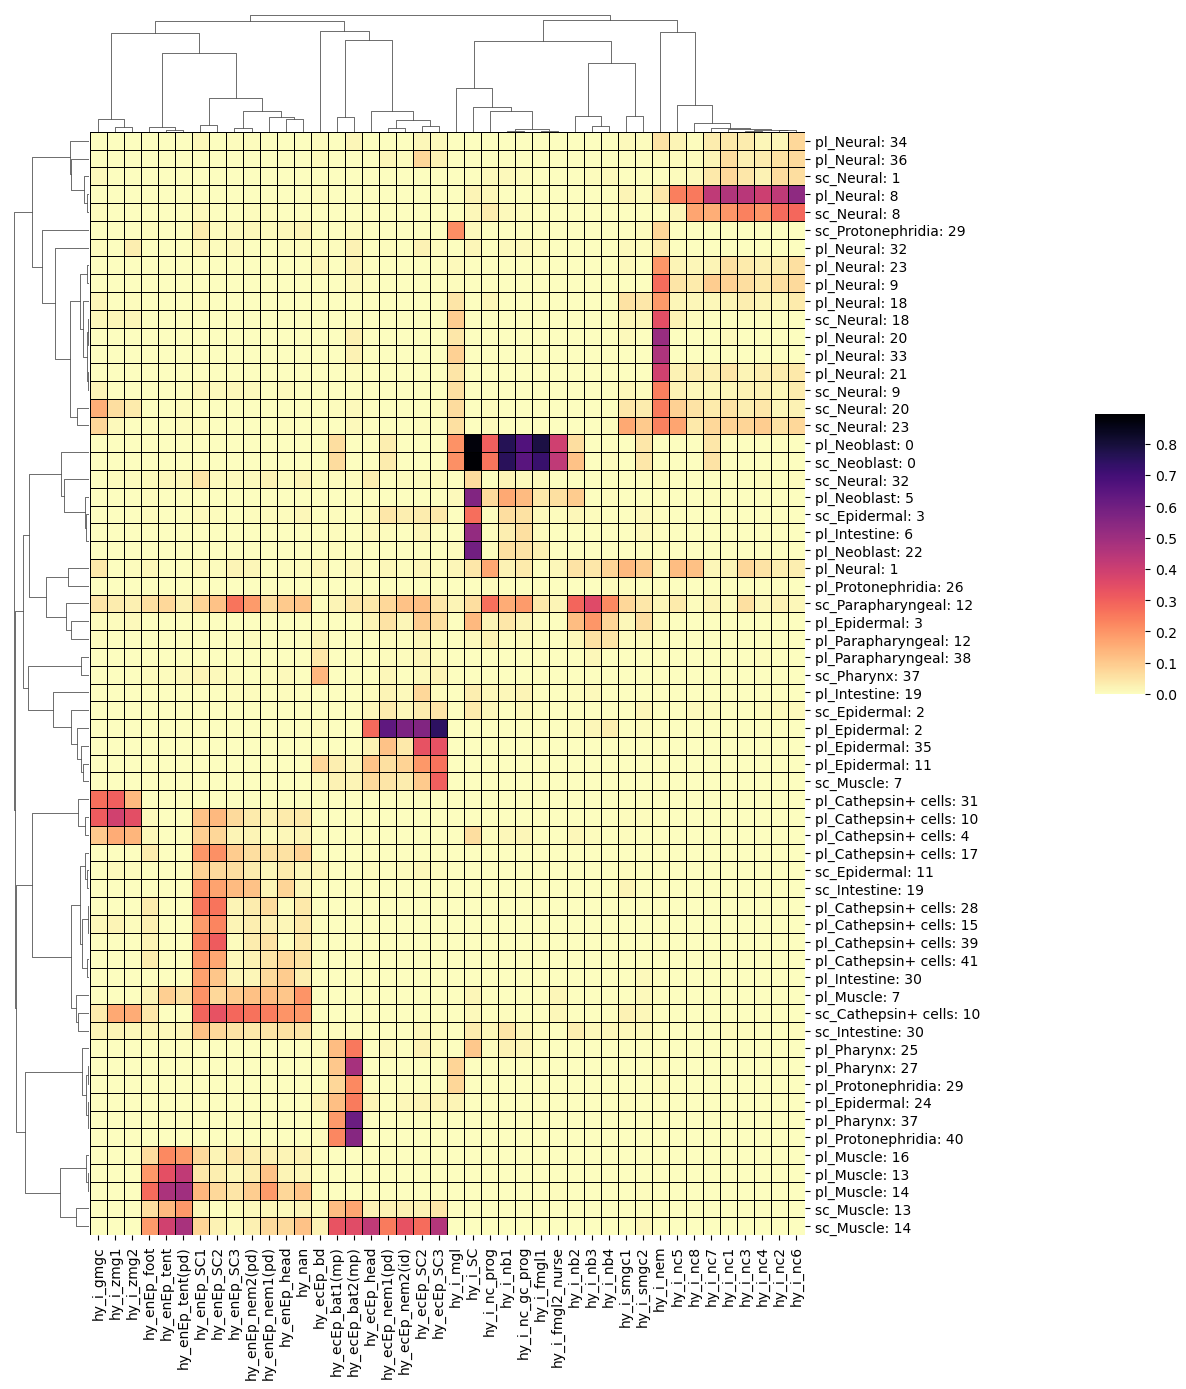

In [12]:
cluster = sns.clustermap(together,
               metric="cosine",
               dendrogram_ratio=0.1,
               linecolor="black",
               linewidths=0.5,
               cmap="magma_r",
               figsize=(10, 14),
               cbar_pos=(1.1, 0.5, 0.05, 0.2))
cluster.savefig("./clustermap.pdf")

This matrix immediately suggests groups of _Hydra_ cell types that find similar groups in flatworms. An immediate next step would be to use custom trees (e.g. via the [Musser _et al._ 2021](https://www.science.org/doi/10.1126/science.abj2949) cell type tree) on the query side, and see if the flatworms agree with the tree.